# Step 1.: Dealing the cards

In [129]:
import os
import random
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import cv2
import numpy as np

def deal_hand_and_flop(base_path, num_cards_probs=[0.35, 0.40, 0.15, 0.10]):
    """
    Select the hand and flop card images based on the given rules.
    - base_path: Base path for card images.
    - num_cards_probs: Probabilities for selecting the number of cards [2, 5, 6, 7].
    Returns:
        hand_cards (list): List of paths for the hand cards.
        flop_cards (list): List of paths for the flop cards.
    """
    # Define card classes and number of cards to draw
    classes = [ '2C', '2D', '2H', '2S',
                '3C', '3D', '3H', '3S',
                '4C', '4D', '4H', '4S',
                '5C', '5D', '5H', '5S', 
                '6C', '6D', '6H', '6S', 
                '7C', '7D', '7H', '7S', 
                '8C', '8D', '8H', '8S', 
                '9C', '9D', '9H', '9S',
                'TC', 'TD', 'TH', 'TS', 
                'AC', 'AD', 'AH', 'AS', 
                'JC', 'JD', 'JH', 'JS',
                'KC', 'KD', 'KH', 'KS', 
                'QC', 'QD', 'QH', 'QS']
    num_cards_options = [2, 5, 6, 7]

    # Step 1: Randomly choose a deck
    deck = random.choice(["first", "second"])
    suffix = "_" if deck == "second" else ""

    #Constructing the bounding box for the yolo format (x_center, y_center, width, height)
    if deck == "first":
        b_box_yolo = [66, 145, 100, 230]
    else:
        b_box_yolo = [45, 90, 90, 180]

    # Step 2: Shuffle and draw a random number of cards
    random.shuffle(classes)
    num_cards = random.choices(num_cards_options, weights=num_cards_probs, k=1)[0]
    selected_classes = classes[:num_cards]

    hand_labels = [[card, b_box_yolo] for card in selected_classes[:2]]
    flop_labels = [[card, b_box_yolo] for card in selected_classes[2:]]

    # Step 3: Generate file paths for the selected cards
    hand_paths = [os.path.join(base_path, f"{suffix}{card}.png") for card in selected_classes[:2]]
    flop_paths = [os.path.join(base_path, f"{suffix}{card}.png") for card in selected_classes[2:]]

    return hand_paths, flop_paths, hand_labels, flop_labels

In [140]:
def yolo_notation2cv2_notation(yolo_notation):
    x, y, w, h = yolo_notation
    #Upper left
    x1 = int(x - w / 2)
    y1 = int(y - h / 2)
    #Upper right
    x2 = x1 + w
    y2 = y1
    #Lower right
    x3 = x2
    y3 = y1 + h
    #Lower left
    x4 = x1
    y4 = y3

    return np.array([[x1, y1], [x2, y2], [x3, y3], [x4, y4]])

def cv2_notation2yolo_notation(cv2_notation):
    x1, y1 = cv2_notation[0]
    x3, y3 = cv2_notation[2]
    
    #Width and height
    w = x3 - x1
    h = y3 - y1

    #Center
    x = x1 + w / 2
    y = y1 + h / 2
    
    return x, y, w, h

def cv2_modified2yolo_notation(cv2_modified):
    # Extract the x and y coordinates from the points
    x_coords = cv2_modified[:, 0]
    y_coords = cv2_modified[:, 1]

    # Calculate the center
    x_center = sum(x_coords) / 4
    y_center = sum(y_coords) / 4

    # Calculate the width and height
    width = max(x_coords) - min(x_coords)
    height = max(y_coords) - min(y_coords)

    return x_center, y_center, width, height

Here is an example of what the first function does

Hand cards:  [['7S', [45, 90, 90, 180]], ['6D', [45, 90, 90, 180]]]


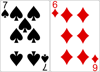

Flop cards: None


In [141]:
from IPython.display import display

benchmarks_path = "../shared_data/benchmark"
hand_paths, flop_paths, hand_labels, flop_labels = deal_hand_and_flop(benchmarks_path)

# Convert cv2 images to PIL images
hand = [Image.open(path).convert("RGBA") for path in hand_paths]
flop = [Image.open(path).convert("RGBA") for path in flop_paths]
hand = [card.resize((int(card.width * 0.1), int(card.height * 0.1))) for card in hand]
flop = [card.resize((int(card.width * 0.1), int(card.height * 0.1))) for card in flop]

# Display hand cards next to each other
hand_combined = Image.new("RGBA", (hand[0].width * len(hand), hand[0].height))
for i, card in enumerate(hand):
    hand_combined.paste(card, (i * card.width, 0))
print("Hand cards: ", hand_labels)
display(hand_combined)

# Display flop cards next to each other
if flop:
    flop_combined = Image.new("RGBA", (flop[0].width * len(flop), flop[0].height))
    for i, card in enumerate(flop):
        flop_combined.paste(card, (i * card.width, 0))
    print("Flop cards: ", flop_labels)
    display(flop_combined)
else:
    print("Flop cards: None")

## Step 1.1: Auxiliary functions

### Independent rotation of the single images

In [144]:
def rotate_image(image, b_box_yolo, angle):
    """
    Rotate the image around its center.
    
    Parameters:
    - image: Input image as a NumPy array (H x W x 3).
    - b_box_yolo: Bounding box in YOLO format (x_center, y_center, width, height).
    - angle: Angle in degrees.
    
    Returns:
    - rotated_image: The rotated image.
    - rotated_bb_yolo: The rotated bounding box in YOLO format.
    """

    h, w = image.shape[:2]
    new_w = int(w * abs(np.cos(np.deg2rad(angle))) + h * abs(np.sin(np.deg2rad(angle))))
    new_h = int(h * abs(np.cos(np.deg2rad(angle))) + w * abs(np.sin(np.deg2rad(angle))))
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    M[0, 2] += (new_w - w) / 2
    M[1, 2] += (new_h - h) / 2

    # Rotate the bounding box
    bb_coords = yolo_notation2cv2_notation(b_box_yolo)
    bb_coords = np.hstack([bb_coords, np.ones((bb_coords.shape[0], 1), dtype=bb_coords.dtype)])
    rotated_points = bb_coords @ M.T
    rotated_bb_yolo = cv2_modified2yolo_notation(rotated_points)

    
    rotated_image = cv2.warpAffine(image, M, (new_w, new_h))
    return rotated_image, rotated_bb_yolo

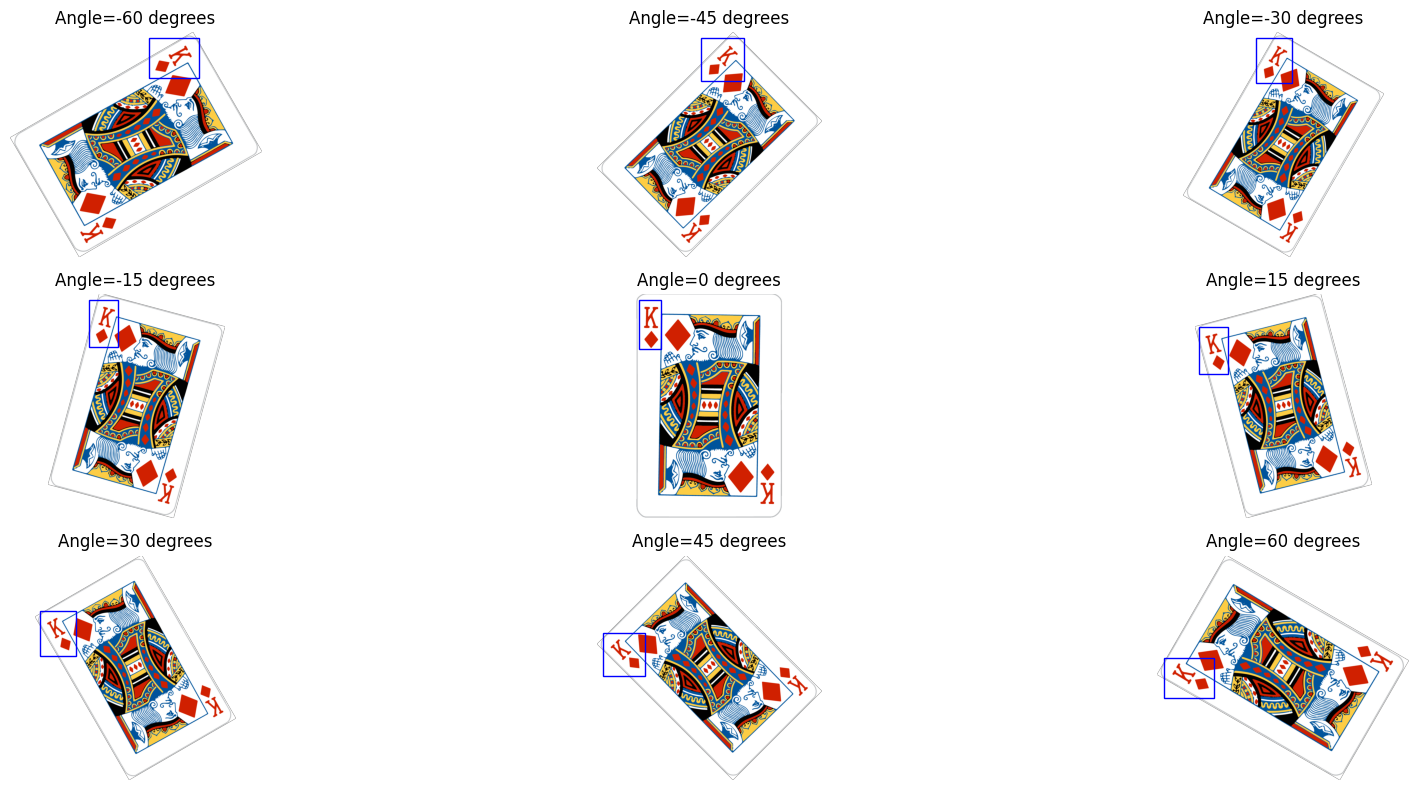

In [151]:
hand, flop, hand_labels, _ = deal_hand_and_flop(benchmarks_path)
hand = cv2.cvtColor(cv2.imread(hand[0]), cv2.COLOR_BGR2RGBA)

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

fig, axes = plt.subplots(3, 3, figsize=(20, 8))

angles = np.arange(-60, 75, 15)
for ax, angle in zip(axes.flatten(), angles):
    rotated_image, rotated_bb_yolo = rotate_image(hand, hand_labels[0][1], angle)
    upper_left = tuple(yolo_notation2cv2_notation(rotated_bb_yolo)[0])
    rect = Rectangle(upper_left, rotated_bb_yolo[2], rotated_bb_yolo[3], linewidth=1, edgecolor='b', facecolor='none')
    ax.add_patch(rect)
    ax.imshow(rotated_image)
    ax.set_title(f"Angle={angle} degrees")
    ax.axis('off')

plt.tight_layout()
plt.show()

### Translation of the images one next to the other

Deal with the hand case first and the flop then

In [ ]:
# TODO: Implement the function to merge the cards in one image.

### Apply some shading and lighting to the images and objects ostacles on the hands

In [ ]:
# TODO: Implement the function to add light and shadow effects to the merged cards.

In [67]:
def overlay_random_transparent_object(base_image: np.ndarray, object_folder: str) -> np.ndarray:
    """
    Overlays a randomly selected transparent image from `object_folder` onto `base_image`.
    Scales the object (hand) so that its height is 110% of the base image's height,
    then places it randomly in the lower 60% of the base image, allowing partial cropping.
    
    Parameters:
        base_image (np.ndarray): The base RGBA image (H x W x 4).
        object_folder (str): Path to the folder containing transparent RGBA images.
    
    Returns:
        np.ndarray: The modified RGBA image after overlay.
    """
    
    # Get a list of all files in the object folder
    object_files = [f for f in os.listdir(object_folder) if not f.startswith('.') and os.path.isfile(os.path.join(object_folder, f))]
    if not object_files:
        raise ValueError("No object files found in the given folder.")
    
    # Randomly select an object image file
    obj_file = random.choice(object_files)
    obj_path = os.path.join(object_folder, obj_file)
    
    # Load the object image with alpha channel
    obj_img = cv2.cvtColor(cv2.imread(obj_path, cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2RGBA) 

    # Randomly mirror the object image with 50% probability
    if random.random() < 0.5:
        obj_img = cv2.flip(obj_img, 1)  # Flip horizontally

    # Get dimensions of base and object
    base_h, base_w = base_image.shape[:2]
    obj_h, obj_w = obj_img.shape[:2]
    
    # Scale the object so that its height is 110% of the base image height
    desired_obj_h = int(1.1 * base_h)
    scale_factor = desired_obj_h / obj_h
    desired_obj_w = int(obj_w * scale_factor)
    obj_img = cv2.resize(obj_img, (desired_obj_w, desired_obj_h), interpolation=cv2.INTER_AREA)
    obj_h, obj_w = obj_img.shape[:2]

    # We want to place the object in the lower 60% of the card
    # That means y should be from 0.4 * base_h to base_h
    y_min = int(0.2 * base_h)
    y_max = base_h  # potentially placing it so that part goes below the card
    
    top_left_y = random.randint(y_min, y_max)
    
    # For x, we can allow some part to fall out of the image as well.
    # Let's choose x from a range that might allow partial clipping on either side.
    # For example, from -obj_w//2 to base_w (allow half the width to go off-screen on the left)
    x_min = -obj_w // 2
    x_max = base_w
    top_left_x = random.randint(x_min, x_max)

    # Compute the overlapping area between the object and the base image
    # Visible region in the base image
    visible_x_start = max(0, top_left_x)
    visible_y_start = max(0, top_left_y)
    visible_x_end = min(base_w, top_left_x + obj_w)
    visible_y_end = min(base_h, top_left_y + obj_h)

    # If there's no overlap, just return the base image as is
    if visible_x_end <= visible_x_start or visible_y_end <= visible_y_start:
        return base_image

    # Corresponding region in the object
    obj_x_start = visible_x_start - top_left_x
    obj_y_start = visible_y_start - top_left_y
    obj_x_end = obj_x_start + (visible_x_end - visible_x_start)
    obj_y_end = obj_y_start + (visible_y_end - visible_y_start)

    # Extract the relevant portion of the object and the alpha channel
    obj_crop = obj_img[obj_y_start:obj_y_end, obj_x_start:obj_x_end, :]
    alpha_obj = obj_crop[:, :, 3] / 255.0

    # Extract the corresponding base area
    base_crop = base_image[visible_y_start:visible_y_end, visible_x_start:visible_x_end, :]
    alpha_base = base_crop[:, :, 3] / 255.0

    # Compute the combined alpha
    combined_alpha = alpha_obj + alpha_base * (1 - alpha_obj)

    # For each color channel: R, G, B
    for c in range(3):
        base_crop[:, :, c] = (
            obj_crop[:, :, c] * alpha_obj +
            base_crop[:, :, c] * alpha_base * (1 - alpha_obj)
        ) / np.maximum(combined_alpha, 1e-6)

    # Update the alpha channel
    base_crop[:, :, 3] = (combined_alpha * 255).astype(np.uint8)

    # Put the blended region back into the base image
    base_image[visible_y_start:visible_y_end, visible_x_start:visible_x_end, :] = base_crop

    return base_image

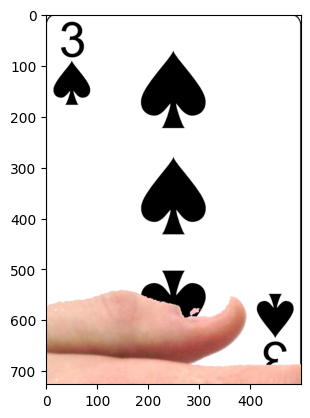

In [81]:
# Example usage:
hand, flop, _, _ = deal_hand_and_flop(benchmarks_path)
hand = cv2.cvtColor(cv2.imread(hand[0]), cv2.COLOR_BGR2RGBA)
modified_image = overlay_random_transparent_object(hand, "../shared_data/objects")
plt.imshow(modified_image)

### Final warping function

In [6]:
def rotate_image_3d_centered(image, pitch, yaw, f=2000):
    """
    Rotate the image in 3D around its center and keep the center of the image stable.
    The output canvas is adjusted so the entire rotated image is visible.
    
    Parameters:
    - image: Input image as a NumPy array (H x W x 3).
    - pitch: Pitch angle in degrees (rotation around x-axis).
    - yaw:   Yaw angle in degrees (rotation around y-axis).
    - f:     Focal length for the projection (in pixels).

    Returns:
    - warped_image: The rotated image, with the center in roughly the same position 
                    and no cutoff.
    """
    h, w = image.shape[:2]

    # Image center
    cx, cy = w / 2.0, h / 2.0

    # Convert angles to radians
    pitch_rad = np.deg2rad(pitch)
    yaw_rad = np.deg2rad(yaw)

    # Rotation matrices
    R_pitch = np.array([
        [1,              0,               0           ],
        [0,  np.cos(pitch_rad), -np.sin(pitch_rad)],
        [0,  np.sin(pitch_rad),  np.cos(pitch_rad)]
    ], dtype=np.float32)

    R_yaw = np.array([
        [ np.cos(yaw_rad), 0, np.sin(yaw_rad)],
        [ 0,               1,              0],
        [-np.sin(yaw_rad), 0, np.cos(yaw_rad)]
    ], dtype=np.float32)

    # Combined rotation
    R = R_yaw @ R_pitch

    # Original corners
    original_corners_2d = np.array([[0,0],
                                    [w,0],
                                    [w,h],
                                    [0,h]], dtype=np.float32)

    corners_3d = np.array([
        [0, 0, 0],
        [w, 0, 0],
        [w, h, 0],
        [0, h, 0]
    ], dtype=np.float32)

    # Center the corners around the image center
    corners_centered = corners_3d - [cx, cy, 0]

    # Rotate corners
    rotated_corners = corners_centered @ R.T

    # Project corners
    Z = rotated_corners[:, 2] + f
    X = rotated_corners[:, 0]
    Y = rotated_corners[:, 1]

    Z[Z == 0] = 0.001
    projected_corners = np.zeros((4, 2), dtype=np.float32)
    projected_corners[:, 0] = (f * X / Z) + cx
    projected_corners[:, 1] = (f * Y / Z) + cy

    # Project the original center to see where it lands
    center_3d = np.array([[cx, cy, 0]], dtype=np.float32)
    center_centered = center_3d - [cx, cy, 0]
    center_rotated = center_centered @ R.T
    Zc = center_rotated[0, 2] + f
    Xc = center_rotated[0, 0]
    Yc = center_rotated[0, 1]
    proj_cx = (f * Xc / Zc) + cx
    proj_cy = (f * Yc / Zc) + cy

    # Compute homography
    H, _ = cv2.findHomography(original_corners_2d, projected_corners)

    # We want the projected center to remain at (cx, cy)
    # So we translate by (cx - proj_cx, cy - proj_cy)
    T_center = np.array([
        [1, 0, cx - proj_cx],
        [0, 1, cy - proj_cy],
        [0, 0, 1]
    ], dtype=np.float32)

    H_adjusted = T_center @ H

    # Apply H_adjusted to corners to find the final bounding box
    ones = np.ones((4,1), dtype=np.float32)
    corners_h = np.hstack([original_corners_2d, ones])
    transformed_corners = (H_adjusted @ corners_h.T).T
    transformed_corners = transformed_corners[:, :2] / transformed_corners[:, 2:3]

    # Compute bounding box
    all_x = transformed_corners[:, 0]
    all_y = transformed_corners[:, 1]
    min_x, max_x = np.min(all_x), np.max(all_x)
    min_y, max_y = np.min(all_y), np.max(all_y)

    new_w = int(np.ceil(max_x - min_x))
    new_h = int(np.ceil(max_y - min_y))

    # We also need to shift so that the bounding box starts at (0,0)
    # We'll add another translation to the homography
    T_box = np.array([
        [1, 0, -min_x],
        [0, 1, -min_y],
        [0, 0, 1]
    ], dtype=np.float32)

    H_final = T_box @ H_adjusted

    # Warp with final homography
    warped_image = cv2.warpPerspective(image, H_final, (new_w, new_h))

    return warped_image

In [ ]:
hand, flop, _, _ = deal_hand_and_flop(benchmarks_path)
hand = cv2.cvtColor(cv2.imread(hand[0]), cv2.COLOR_BGR2RGBA)

fig, axes = plt.subplots(2, 5, figsize=(20, 8))

f_values = np.arange(750, 3250, 250)
for ax, f in zip(axes.flatten(), f_values):
    rotated_image = rotate_image_3d_centered(hand, pitch=-75, yaw=0, f=f)
    ax.imshow(cv2.cvtColor(rotated_image, cv2.COLOR_RGBA2BGRA))
    ax.set_title(f"f={int(f)}")
    ax.axis('off')

plt.tight_layout()
plt.show()

# Step 2.: Add the modified Hand Cards to the background images

In [ ]:
# TODO: Use all the auxiliary functions with random angles and variables to generate a synthetic hand and flop to be at the end added to a background picture.
# TODO: Modify all the functions above so to create the bounding boxes and the labels for the cards (try both oriented and non-oriented bounding boxes).

In [ ]:
import cv2
import numpy as np
import random

def create_synthetic_image(image_paths):
    # Load images
    images = [cv2.imread(path) for path in image_paths]
    
    # Assuming both images have the same size
    height, width, _ = images[0].shape
    
    # Rotate each image independently
    angle1 = random.uniform(-60, 60)
    angle2 = random.uniform(-60, 60)
    
    rotated_image1 = rotate_image(images[0], angle1)
    rotated_image2 = rotate_image(images[1], angle2)
    
    # Create a new image with extra padding
    padding = 50
    new_width = width * 2 + padding * 2
    new_height = height + padding * 2
    new_image = np.ones((new_height, new_width, 3), dtype=np.uint8) * 255
    
    # Calculate random distance between centers
    max_distance = int(1.05 * width)
    min_distance = int(0.2 * width)
    distance = random.randint(min_distance, max_distance)
    
    # Place images next to each other with random distance
    x1 = padding
    y1 = padding
    x2 = x1 + distance
    y2 = padding
    
    new_image[y1:y1+height, x1:x1+width] = blurred_image1
    new_image[y2:y2+height, x2:x2+width] = blurred_image2
    
    # Use the rotate_image_3d_centered function
    # Assuming rotate_image_3d_centered is defined elsewhere and takes an image as input
    final_image = rotate_image_3d_centered(new_image)
    
    return final_image

# Example usage
# image_paths = ['path_to_image1.jpg', 'path_to_image2.jpg']
# result_image = create_synthetic_image(image_paths)
# cv2.imshow('Result Image', result_image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()